# Кластеризация k-means

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Константы

In [2]:
DATA_PATH = "../Lesson43/penguins.csv"
RANDOM_STATE = 777

## Загрузка данных

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


## Исследовательский анализ данных

Проверка дубликатов.

In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 1


Удаление дубликатов.

In [6]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [7]:
# Выделим числовые и категориальные признаки
numeric_columns = [
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]
categoric_columns = ["sex"]

In [8]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)
    return stats


def categoric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Количество уникальных значений"] = df.nunique()
    stats["Мода"] = df.mode().transpose()
    return stats

In [9]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.002915,32.1,59.6,43.92,44.45,29.81,36.6,50.8,39.22,48.50
culmen_depth_mm,0.002915,13.1,21.5,17.15,17.30,3.90,14.3,19.5,15.60,18.70
flipper_length_mm,0.002915,-132.0,5000.0,214.01,197.00,67890.50,185.0,221.0,190.00,213.75
body_mass_g,0.002915,2700.0,6300.0,4201.75,4050.00,643131.08,3300.0,5400.0,3550.00,4750.00


In [10]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.023324,3,MALE


Удалим пропуски в данных.

In [11]:
df = df.dropna()
df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Проверим колонку "sex".

In [12]:
df["sex"].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

In [13]:
df = df.drop(df[df["sex"] == "."].index)
df["sex"].value_counts()

sex
MALE      169
FEMALE    165
Name: count, dtype: int64

### Распределение категориальной переменной

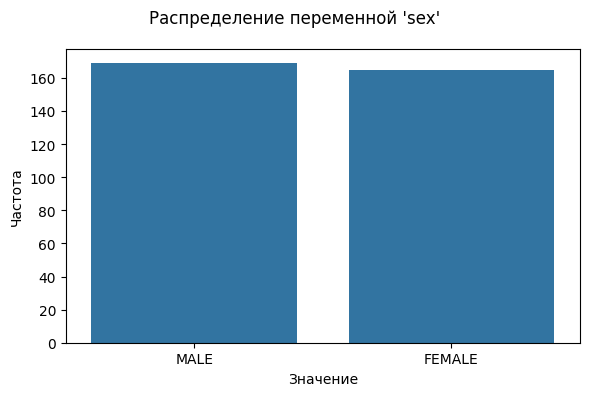

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(df["sex"].value_counts(), ax=ax)
ax.set_xlabel("Значение")
ax.set_ylabel("Частота")

plt.suptitle(f"Распределение переменной 'sex'")
plt.tight_layout()
plt.show()

Значения распределены примерно поровну.

### Распределение числовых переменных

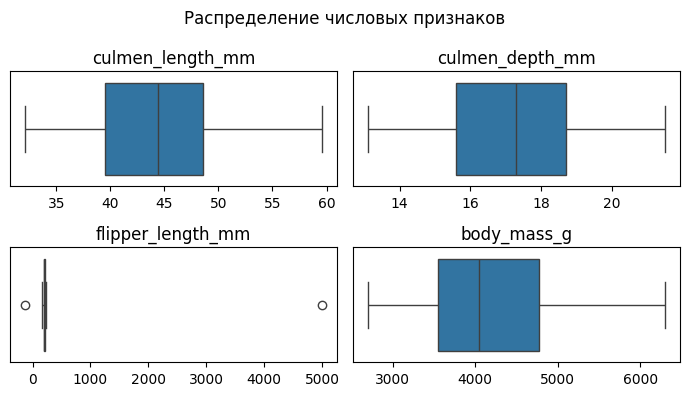

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(7, 4))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 2)
    sns.boxplot(df[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(numeric_columns), len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков")
plt.tight_layout()
plt.show()

Можно видеть, что столбец flipper_length_mm имеет два выброса.

In [16]:
print(df[df["flipper_length_mm"] > 4000])
print(df[df["flipper_length_mm"] < 0])

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g   sex
9              42.0             20.2             5000.0       4250.0  MALE
    culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g   sex
14              34.6             21.1             -132.0       4400.0  MALE


Удалим их из набора данных.

In [17]:
df = df.drop([9, 14])

Проверим параметры данных после преобразований.

In [18]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.0,32.1,59.6,44.02,44.7,29.73,36.61,50.8,39.5,48.62
culmen_depth_mm,0.0,13.1,21.5,17.15,17.3,3.84,14.31,19.5,15.6,18.70
flipper_length_mm,0.0,172.0,231.0,200.98,197.0,197.01,185.00,221.0,190.0,213.00
body_mass_g,0.0,2700.0,6300.0,4206.48,4025.0,650218.51,3300.00,5445.0,3550.0,4781.25


In [19]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.0,2,MALE


### Анализ корреляций

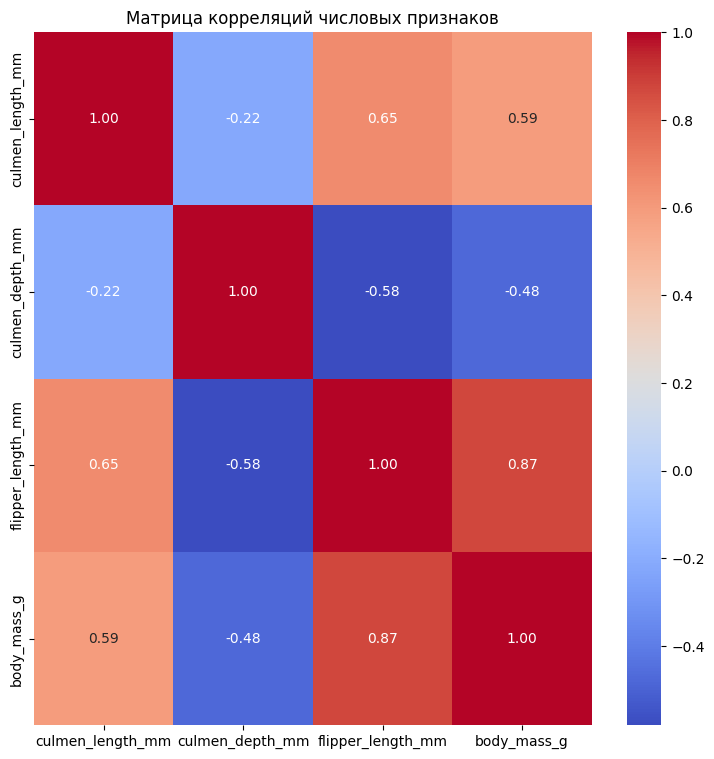

In [20]:
plt.figure(figsize=(9, 9))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

В данных присутствуют ожидаемые корреляции между flipper_length_mm - body_mass_g, flipper_length_mm - culmen_length_mm. Оставим данные без изменений.

### Масштабирование данных

In [21]:
df_scaled = df.copy()

le = LabelEncoder()
scaler = StandardScaler()

df_scaled["sex"] = le.fit_transform(df_scaled["sex"])
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df.columns)

df_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.903906,0.790360,-1.425342,-0.566948,0.993994
1,-0.830434,0.126187,-1.068577,-0.504847,-1.006042
2,-0.683490,0.432728,-0.426399,-1.187953,-1.006042
3,-1.344738,1.096901,-0.569105,-0.939551,-1.006042
4,-0.867170,1.761074,-0.783164,-0.691149,0.993994


## Кластеризация KMeans

### Подбор гиперпараметров

In [22]:
# Подберем гиперпараметры для фиксированного количества кластеров
inertia = float("inf")
params = None

for init in ["k-means++", "random"]:
    for algorithm in ["lloyd", "elkan"]:
        kmeans = KMeans(
            n_clusters=4,
            random_state=RANDOM_STATE,
            max_iter=1000,
            init=init,
            algorithm=algorithm,
        )
        kmeans.fit(df_scaled)
        if kmeans.inertia_ < inertia:
            inertia = kmeans.inertia_
            params = kmeans.get_params()

del params["n_clusters"]

print(f"Гиперпараметры после подбора: {params}")

Гиперпараметры после подбора: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 1000, 'n_init': 'auto', 'random_state': 777, 'tol': 0.0001, 'verbose': 0}


### Оценка качества кластеризации методом локтя

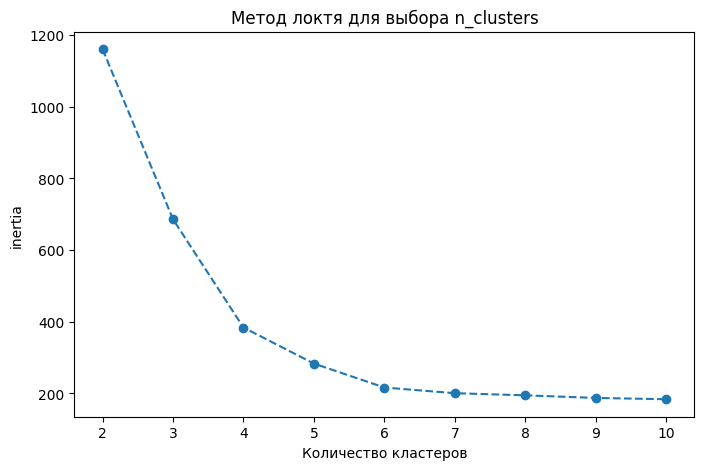

In [23]:
clasters_range = range(2, 11)
inertia = []

for n_clusters in clasters_range:
    kmeans = KMeans(n_clusters=n_clusters, **params)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(8, 5))
plt.plot(clasters_range, inertia, marker="o", linestyle="--")
plt.xlabel("Количество кластеров")
plt.ylabel("inertia")
plt.title("Метод локтя для выбора n_clusters")
plt.show()

Судя по скорости убывания графика, можно заключить, что оптимальным количеством кластеров является количество от 4 до 6 (включительно), после этого скорость убывания заметно снижается.

### Оценка качества кластеризации методом силуэта

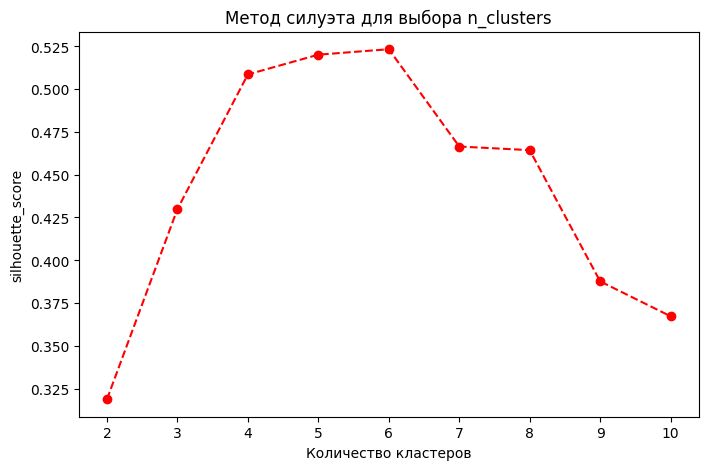

In [24]:
clasters_range = range(2, 11)
silhouette_scores = []

for n_clusters in clasters_range:
    kmeans = KMeans(n_clusters=n_clusters, **params)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Визуализация метода силуэта
plt.figure(figsize=(8, 5))
plt.plot(clasters_range, silhouette_scores, marker="o", linestyle="--", color="r")
plt.xlabel("Количество кластеров")
plt.ylabel("silhouette_score")
plt.title("Метод силуэта для выбора n_clusters")
plt.show()

Можно видеть, что максимум на графике силуэта достигается в диапазоне количества кластеров от 4 до 6 (включительно), что согласуется с методом локтя.

- Ориентируясь на графики метода локтя и метода силуэта выберем количество кластеров равное **6**.

###  Визуализация кластеров

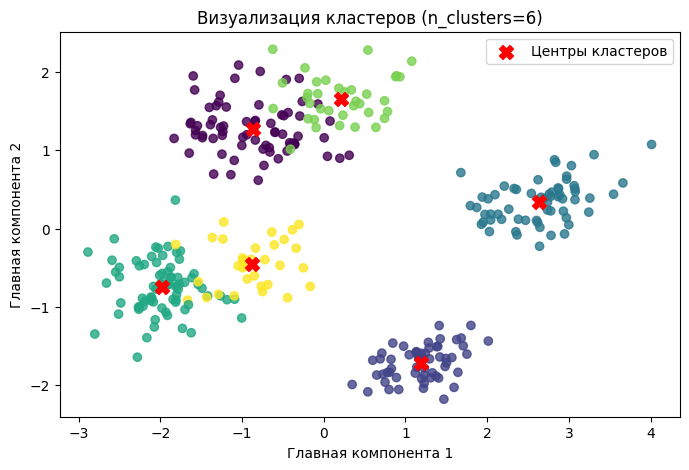

In [25]:
# Модель KMeans с оптимальным количеством кластеров
OPTIMAL_N_CLUSTERS = 6
kmeans_fine_tune = KMeans(n_clusters=OPTIMAL_N_CLUSTERS, **params)
kmeans_fine_tune.fit(df_scaled)

# Визуализация кластеров после снижения размерности
pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled.values)
cluster_centers_pca = pca.transform(kmeans_fine_tune.cluster_centers_)

plt.figure(figsize=(8, 5))
plt.scatter(
    df_scaled_pca[:, 0],
    df_scaled_pca[:, 1],
    c=kmeans_fine_tune.labels_,
    alpha=0.8,
)
plt.scatter(
    cluster_centers_pca[:, 0],
    cluster_centers_pca[:, 1],
    c="red",
    marker="X",
    s=100,
    label="Центры кластеров",
)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title(f"Визуализация кластеров (n_clusters={OPTIMAL_N_CLUSTERS})")
plt.legend()
plt.show()

На графике, после снижения размерности, можно видеть набор хорошо различимых кластеров.

###  Сохранение модели

In [26]:
joblib.dump(kmeans_fine_tune, "kmeans_model.joblib")
print("Модель сохранена!")

Модель сохранена!
